# IDC Cancer Classification Walkthrough

This notebook walks through loading the IDC patch dataset, preparing splits by subject ID, creating loaders, initializing the ResNet18 transfer-learning model, and running a short training/evaluation cycle. It reuses the project modules in `src/`.


In [1]:
import os
import sys
from pathlib import Path
import itertools

# Add project root to sys.path for imports
PROJECT_ROOT = Path("/Users/michaelcheng/Desktop/AI_projects/kaggle_cancer_classification")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: /Users/michaelcheng/Desktop/AI_projects/kaggle_cancer_classification


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt


# Build Data Loaders

In [11]:
from typing import Tuple, List, Optional
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class IDCDataset(Dataset):
    """Dataset for IDC cancer images with nested subject ID structure.
    
    Structure: {data_root}/{subject_id}/{0|1}/*.png
    """

    def __init__(self, data_root: str, subject_ids: List[str], transform: Optional[transforms.Compose] = None):
        self.data_root = Path(data_root)
        self.transform = transform

        self.subject_ids = subject_ids
        self.samples: List[Tuple[str, int]] = []
        # collect all image paths and labels
        for subject_id in self.subject_ids:
            subject_dir = self.data_root / subject_id
            # load negative class
            neg_dir = subject_dir / "0"
            neg_samples = 0
            if neg_dir.exists():
                for img_path in neg_dir.glob("*.png"):
                    self.samples.append((str(img_path), 0))
                    neg_samples += 1
            # load positive class
            pos_dir = subject_dir / "1"
            pos_samples = 0
            if pos_dir.exists():
                for img_path in pos_dir.glob("*.png"):
                    self.samples.append((str(img_path), 1))
                    pos_samples += 1
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Get image and label by index.
        returns Tuple of (image tensor, label)"""

        img_path, label = self.samples[idx]

        # load image
        image = Image.open(img_path).convert("RGB")
        # transform image
        if self.transform:
            image = self.transform(image)

        return image, label

        

In [12]:
# train / val / test split
def split_subject_by_id(data_root: str, val_ratio: float = 0.25, test_ratio: float = 0.2, random_seed: int = 42) -> Tuple[List[str], List[str], List[str]]:
    """Split subjects by ID into train/val/test sets.
    
    Args:
        data_root: Root directory containing subject ID folders
        val_ratio: Proportion of subjects for validation
        test_ratio: Proportion of subjects for testing
        random_seed: Random seed for reproducibility
    
    Returns:
        Tuple of (train_ids, val_ids, test_ids)
    """
    subject_ids = os.listdir(data_root)
    np.random.seed(random_seed)
    np.random.shuffle(subject_ids)
    n_total = len(subject_ids)
    n_test = int(n_total * test_ratio)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_test - n_val
    train_ids = subject_ids[:n_train]
    val_ids = subject_ids[n_train:n_train + n_val]
    test_ids = subject_ids[n_train + n_val:]
    return train_ids, val_ids, test_ids

In [13]:
# image transforms
def get_transform(image_size: int, mode: str) -> transforms.Compose:
    """Get image transforms based on mode.
    
    Args:
        image_size: Size to resize images to
        mode: "train" or "val"
    """
    if mode == "train":
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])

In [14]:
def create_dataloaders(data_root: str, batch_size: int, num_workers: int, val_ratio: float, test_ratio: float, image_size: int, random_seed: int) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Create train/val/test dataloaders with subject-based splitting.
    
    Args:
        data_root: Root directory containing subject ID folders
        batch_size: Batch size for all loaders
        num_workers: Number of worker processes for data loading
        val_ratio: Proportion of subjects for validation
        test_ratio: Proportion of subjects for testing
        image_size: Target image size
        random_seed: Random seed for reproducibility
    
    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    
    """

    train_ids, val_ids, test_ids = split_subject_by_id(data_root=data_root, val_ratio=val_ratio, test_ratio=test_ratio, random_seed=random_seed)

    # create datasets
    train_dataset = IDCDataset(data_root=data_root, subject_ids=train_ids, transform=get_transform(image_size=image_size, mode="train"))
    val_dataset = IDCDataset(data_root=data_root, subject_ids=val_ids, transform=get_transform(image_size=image_size, mode="val"))
    test_dataset = IDCDataset(data_root=data_root, subject_ids=test_ids, transform=get_transform(image_size=image_size, mode="val"))

    # create dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader, val_loader, test_loader


    

# Build Model

In [16]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128 x 128 image with 2 pools of size 2 -> 128/2/2 = 32 -> 32 x 32 image dimension.
        # created 24 output channels, so 24*32*32 is the flattened dimension to feed into the final layer
        self.fc1 = nn.Linear(in_features=24*32*32, out_features=1)
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        # add some dropout to prevent overfitting
        x = F.relu(self.dropout(self.conv3(x)))
        # flatten the output
        x = x.view(-1, 24*32*32)
        # dropout in training
        x = F.dropout(x, training=self.training)
        x = self.fc1(x)
        # sigmoid to get a probability output
        x = F.sigmoid(x)
        return x
    



        

# Training and Testing Functions

In [77]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, epoch: int, max_training_batches: int = None):
    # set model to training mode
    model.train()
    train_loss = 0.0
    print("Epoch: ", epoch)
    if max_training_batches is not None:
        train_loader = itertools.islice(train_loader, max_training_batches)
    for batch_idx, (data, target) in enumerate(train_loader):
        # move data to device (need to target as a batch of 1)
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        # reset gradients        
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # compute loss
        loss = criterion(output, target)
        # keep running total
        train_loss += loss.item()
        # backpropogate
        loss.backward()
        # update weights
        optimizer.step()

        # print loss after every 10 batches
        if batch_idx % 100 == 0:
            print(f"Train Loss: {train_loss:.6f}")
    
    # print average loss
    avg_loss = train_loss / (batch_idx + 1)
    print(f"Average training loss: {avg_loss:.6f}")
    return avg_loss


def test_model(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            # forward pass
            output = model(data)
            # comput loss
            loss = criterion(output, target)
            # keep running total
            test_loss += loss.item()
            # get predictions
            pred = output.round()
            # update correct count
            correct += pred.eq(target).sum().item()
            # print loss after every 10 batches
            if batch_idx % 100 == 0:
                print(f"Test Loss: {test_loss:.6f}")
    
    avg_loss = test_loss / (batch_idx + 1)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


# Optimizer and Loss Function

In [36]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = cnn()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

# Training and Testing Loop

In [ ]:
data_root = PROJECT_ROOT / "IDC_regular_ps50_idx5"
batch_size = 32
val_ratio = 0.25
test_ratio = 0.2
image_size = 128
num_workers = 0
random_seed = 42
max_training_batches = None
num_epochs = 10

In [78]:
train_loader, val_loader, test_loader = create_dataloaders(data_root=data_root, batch_size=batch_size, num_workers=num_workers, val_ratio=val_ratio, test_ratio=test_ratio, image_size=image_size, random_seed=random_seed)

In [79]:
len(train_loader)

1036

In [80]:
for epoch in range(num_epochs): 
    train_model(model, device, train_loader, val_loader, criterion, optimizer, epoch=epoch, max_training_batches=max_training_batches)

Epoch:  0
Train Loss: 0.288939
Train Loss: 36.667025
Train Loss: 71.860561
Train Loss: 107.203399
Train Loss: 142.334077
Train Loss: 176.475295
Train Loss: 209.308469
Train Loss: 245.070798
Train Loss: 278.745645
Train Loss: 314.420453
Train Loss: 349.221374
Average training loss: 0.348081
Epoch:  1
Train Loss: 0.346234
Train Loss: 33.181564
Train Loss: 67.299998
Train Loss: 100.308967
Train Loss: 132.244472
Train Loss: 164.865137
Train Loss: 199.148097
Train Loss: 231.902497
Train Loss: 263.371959
Train Loss: 295.505451
Train Loss: 328.782639
Average training loss: 0.328143
Epoch:  2
Train Loss: 0.431215
Train Loss: 31.809772
Train Loss: 62.718572
Train Loss: 93.315312
Train Loss: 124.400707
Train Loss: 156.967931
Train Loss: 189.714130
Train Loss: 221.807181
Train Loss: 252.358685
Train Loss: 286.365653
Train Loss: 318.604069
Average training loss: 0.317712
Epoch:  3
Train Loss: 0.309925
Train Loss: 30.228475
Train Loss: 60.818413
Train Loss: 91.180782
Train Loss: 124.110787
Train Lo

In [81]:
test_model(model, device, val_loader, criterion)

Test Loss: 0.298149
Test Loss: 44.461324
Test Loss: 87.352998
Test Loss: 128.189635
Test Loss: 172.695911
Test Loss: 214.246937
Test Loss: 0.427492, Accuracy: 81.78%


(0.4274923128356773, 81.78487144454105)

In [82]:
# test and evaluate model
from sklearn.metrics import confusion_matrix
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        output = model(data)
        pred = output.round()
        true_labels.extend(target.cpu().numpy().flatten())
        predicted_labels.extend(pred.cpu().numpy().flatten())


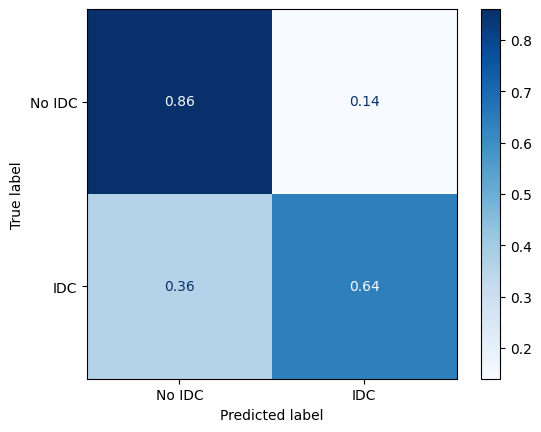

In [83]:
# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, display_labels=["No IDC", "IDC"], cmap=plt.cm.Blues, normalize="true")

# plt.xlabel("Predicted")
# plt.ylabel("Actual")
plt.show()